## Claude Monet Genre Classifier

The purpose of this notebook is to explore and build a model that is capable of accurately classifying Claude Monet's work. The data that the model will be training and tested on comes from www.wikiart.org.

Let's begin by importing libraries that we will need to build our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

Now, we load in the data that will be used for the model. 

**Note:** The features in this data set consists of information that was webscraped from www.wikiart.org and features that were generated on Monet's work computationally. The code that was used to generate these features are in the `/code` folder of this repository.

In [2]:
# Loading in data
images = pd.read_csv('../data/data.csv')
images = images.drop(['name', 'style'], axis=1)
images.head()

,date,genre,height,width,mean_hue,mean_saturation,mean_value,mean_energy,edge_count,has_face
0,1864,cityscape,848,1280,0.161592,0.369811,0.639680,1581.759686,848,0
1,1858,landscape,797,1280,0.418561,0.323907,0.559839,1304.028243,797,0
2,1861,self-portrait,1273,881,0.465204,0.360307,0.356693,9083.166369,1273,0
3,1862,still life,1200,850,0.300296,0.622229,0.386603,1323.287669,1200,0
4,1863,landscape,974,1280,0.129511,0.490746,0.463133,1584.791794,974,0


### Genre Adjustment

Our classifier will attempt to predict the `genre` class from the other features. However, there seems to be too many genres and a misbalance between them as well:

In [3]:
images['genre'].value_counts()

landscape          780
cityscape          256
flower painting    165
genre painting      70
portrait            35
marina              32
still life          18
self-portrait        5
animal painting      2
architecture         1
Name: genre, dtype: int64

We noticed that although they are each different genres, some of these genres share similarities. For example, the genres 'painting', 'portrait', and 'self-portrait' typically depict people. Therefore, we will group these genres together into a single `people` genre. Other genres such as 'architecture', 'animal painting', 'still life', and 'marina' are sparse in the data set and/or, from our understanding, unrelated to the others. Therefore, we will not be working with these genres.

In [4]:
# Creating people genre
people_genres = ['genre painting', 'portrait', 'self-portrait']
images['genre'] = images['genre'].apply(lambda x: 'people' if x in people_genres else x)

# Removing unused genres
removed_genres = ['marina', 'still life', 'animal painting', 'architecture']
images = images[~images['genre'].isin(removed_genres)]

In [5]:
images['genre'].value_counts()

landscape          780
cityscape          256
flower painting    165
people             110
Name: genre, dtype: int64

In [6]:
len(images)

1311

The data set has now been minimized to 4 genres. A misbalance still exists so this will be taken into consideration going forward.

### Data Preparation

In order to build the classifier, the features our model will train on must be numerical. Thankfully all of the features are numerical. However, 'date' should instead be treated as categorical due to the fact that one year is not necessarily larger than another year (atleast for the purposes of this project).

Let's examine the number of unique years in this data set:

In [7]:
images['date'].nunique()

60

Typically, we could one hot encode these features but encoding 60 different years this way may not be so ideal. Instead, we will group the years into their respective decade:

In [8]:
images['date'] = images['date'].apply(lambda x: str(x)[:3]+'0')
images['date'].value_counts()

1880    438
1870    301
1890    183
1900    164
1860     88
1910     86
1920     50
1850      1
Name: date, dtype: int64

We have now minimized this down to 8 different decades! Now we can proceed with one hot encoding.

In [9]:
encoded_dates = pd.get_dummies(images['date'])
images = pd.concat([images, encoded_dates], axis=1)
images = images.drop('date', axis=1)
images.head()

,genre,height,width,mean_hue,mean_saturation,mean_value,mean_energy,edge_count,has_face,1850,1860,1870,1880,1890,1900,1910,1920
0,cityscape,848,1280,0.161592,0.369811,0.639680,1581.759686,848,0,0,1,0,0,0,0,0,0
1,landscape,797,1280,0.418561,0.323907,0.559839,1304.028243,797,0,1,0,0,0,0,0,0,0
2,people,1273,881,0.465204,0.360307,0.356693,9083.166369,1273,0,0,1,0,0,0,0,0,0
4,landscape,974,1280,0.129511,0.490746,0.463133,1584.791794,974,0,0,1,0,0,0,0,0,0
6,landscape,907,1280,0.327326,0.226113,0.711511,2491.539824,907,0,0,1,0,0,0,0,0,0


Lastly, we assign numaerical values to each of the genres.

In [10]:
genre_encoder = {'landscape': 0, 'cityscape': 1, 
                 'flower painting': 2, 'people': 3}
images['genre'] = images['genre'].replace(genre_encoder)
images.head()

,genre,height,width,mean_hue,mean_saturation,mean_value,mean_energy,edge_count,has_face,1850,1860,1870,1880,1890,1900,1910,1920
0,1,848,1280,0.161592,0.369811,0.639680,1581.759686,848,0,0,1,0,0,0,0,0,0
1,0,797,1280,0.418561,0.323907,0.559839,1304.028243,797,0,1,0,0,0,0,0,0,0
2,3,1273,881,0.465204,0.360307,0.356693,9083.166369,1273,0,0,1,0,0,0,0,0,0
4,0,974,1280,0.129511,0.490746,0.463133,1584.791794,974,0,0,1,0,0,0,0,0,0
6,0,907,1280,0.327326,0.226113,0.711511,2491.539824,907,0,0,1,0,0,0,0,0,0


### Model Building

We will now be construcitng our model. A series of machine learning algortihms will be tested and tuned to determine which is best for classifying Monet's work.

First we must split the data into a training and validation test – a 75/25 split will be used.

In [11]:
X = images.drop('genre', axis=1)
y = images['genre']

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.25, 
                                    random_state=0
                                    )

#### Logistic Regression

In [12]:
lg_parameters = {'tol':[.1, .001, .0001], 'C':[10, 1, .1]}
lg = LogisticRegression()
clf1 = GridSearchCV(lg, lg_parameters)

clf1.fit(X_train, y_train)
preds_lg = clf1.predict(X_test)
accuracy_lr = np.round(np.mean(y_test == preds_lg)*100, 2)

print('The accuracy for the Logistic Regression model is {}%'.format(accuracy_lr))

The accuracy for the Logistic Regression model is 73.17%


In [13]:
# Creating dataframe of predictions and truth
class_map = {0: 'landscape', 1: 'cityscape', 
             2: 'flower painting', 3: 'people'}
classifier_df = pd.DataFrame({'True':y_test, 
                              'Predicted': preds_lg})
classifier_df['Genre'] = classifier_df['True'].replace(class_map)

# Computing accuracy across classes
print('Class Accuracies:')
lr_accuracies = classifier_df.groupby('Genre').apply(lambda x: np.mean(x['True'] == x['Predicted']))
lr_accuracies

Class Accuracies:


Genre
cityscape          0.500000
flower painting    0.369565
landscape          0.931373
people             0.200000
dtype: float64

#### K Nearest Neighbors

In [14]:
knn_parameters = {'n_neighbors':[10, 5, 3, 1], 'p':[2, 1]}
knn = KNeighborsClassifier()
clf2 = GridSearchCV(knn, knn_parameters)

clf2.fit(X_train, y_train)
preds_knn = clf2.predict(X_test)
accuracy_knn2 = np.mean(y_test == preds_knn)*100

print('The accuracy for the K Nearest Neighbors model is {}%'.format(accuracy_knn2))

The accuracy for the K Nearest Neighbors model is 61.58536585365854%


In [15]:
classifier_df = pd.DataFrame({'True':y_test, 
                              'Predicted': preds_knn})
classifier_df['Genre'] = classifier_df['True'].replace(class_map)

# Computing accuracy across classes
print('Class Accuracies:')
knn_accuracies = classifier_df.groupby('Genre').apply(lambda x: np.mean(x['True'] == x['Predicted']))
knn_accuracies

Class Accuracies:


Genre
cityscape          0.034483
flower painting    0.065217
landscape          0.965686
people             0.000000
dtype: float64

#### Support Vector Machine

In [16]:
svc_parameters = {'tol': [.1, .001, .0001], 'C':[10, 1, .1]}
svc = SVC()
clf3 = GridSearchCV(svc, svc_parameters)

clf3.fit(X_train, y_train)
preds_svc = clf3.predict(X_test)
accuracy_svc2 = np.mean(y_test == preds_svc)*100

print('The accuracy for the Support Vector Machine model is {}%'.format(accuracy_svc2))

The accuracy for the Support Vector Machine model is 62.19512195121951%


In [17]:
classifier_df = pd.DataFrame({'True':y_test, 
                              'Predicted': preds_svc})
classifier_df['Genre'] = classifier_df['True'].replace(class_map)

# Computing accuracy across classes
print('Class Accuracies:')
svm_accuracies = classifier_df.groupby('Genre').apply(lambda x: np.mean(x['True'] == x['Predicted']))
svm_accuracies

Class Accuracies:


Genre
cityscape          0.0
flower painting    0.0
landscape          1.0
people             0.0
dtype: float64

#### Naive Bayes'

In [18]:
gnb_parameters = {'var_smoothing':[1e-3, 1e-6, 1e-9]}
gnb = GaussianNB()
clf4 = GridSearchCV(gnb, gnb_parameters)

clf4.fit(X_train, y_train)
preds_gnb = clf4.predict(X_test)
accuracy_gnb2 = np.mean(y_test == preds_gnb)*100

print('The accuracy for the Naive Bayes model is {}%'.format(accuracy_gnb2))

The accuracy for the Naive Bayes model is 62.19512195121951%


In [19]:
classifier_df = pd.DataFrame({'True':y_test, 
                              'Predicted': preds_gnb})
classifier_df['Genre'] = classifier_df['True'].replace(class_map)

# Computing accuracy across classes
print('Class Accuracies:')
nb_accuracies = classifier_df.groupby('Genre').apply(lambda x: np.mean(x['True'] == x['Predicted']))
nb_accuracies

Class Accuracies:


Genre
cityscape          0.034483
flower painting    0.000000
landscape          0.990196
people             0.000000
dtype: float64

#### Random Forest

In [20]:
rf_parameters = {'n_estimators':[500, 100, 50, 10]}
rf = RandomForestClassifier()
clf5 = GridSearchCV(rf, rf_parameters)

clf5.fit(X_train, y_train)
preds_rf = clf5.predict(X_test)
accuracy_rf2 = np.mean(y_test == preds_rf)*100

print('The accuracy for the Random Forest model is {}%'.format(accuracy_rf2))

The accuracy for the Random Forest model is 79.26829268292683%


In [21]:
classifier_df = pd.DataFrame({'True':y_test, 
                              'Predicted': preds_rf})
classifier_df['Genre'] = classifier_df['True'].replace(class_map)

# Computing accuracy across classes
print('Class Accuracies:')
rf_accuracies = classifier_df.groupby('Genre').apply(lambda x: np.mean(x['True'] == x['Predicted']))
rf_accuracies

Class Accuracies:


Genre
cityscape          0.568966
flower painting    0.717391
landscape          0.931373
people             0.200000
dtype: float64

Let's plot and summarize the final results.

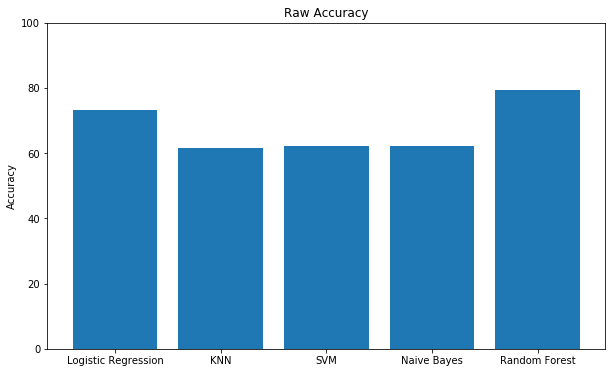

In [24]:
# Raw Accuracies
models = ['Logistic Regression', 'KNN', 'SVM', 'Naive Bayes', 'Random Forest']
accuracies = [accuracy_lr, accuracy_knn2, accuracy_svc2, accuracy_gnb2, accuracy_rf2]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.ylim(0, 100)
plt.ylabel('Accuracy')
plt.title('Raw Accuracy');

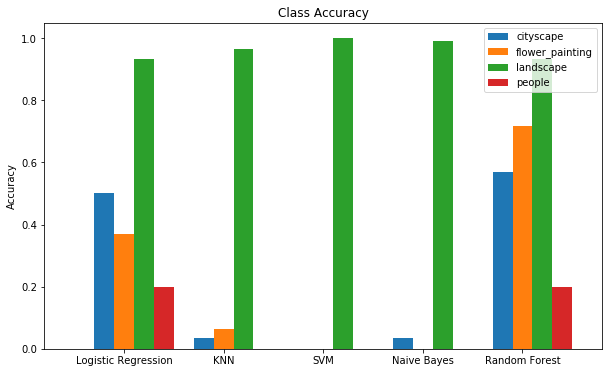

In [25]:
# Class accuracies

formatted_accuracies = list(zip(lr_accuracies, knn_accuracies, 
                                svm_accuracies, nb_accuracies, rf_accuracies))
df = pd.DataFrame(dict(graph=models,
                       cityscape=formatted_accuracies[0], 
                       flower_painting=formatted_accuracies[1], 
                       landscape=formatted_accuracies[2], 
                       people=formatted_accuracies[3])
                 ) 

ind = np.arange(len(df))
width = .2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ind, df.cityscape, width, label='cityscape')
ax.bar(ind + width, df.flower_painting, width, label='flower_painting')
ax.bar(ind + (2*width), df.landscape, width, label='landscape')
ax.bar(ind + (3*width), df.people, width, label='people')

ax.set(xticks=ind + width, xticklabels=df.graph, xlim=[2*width - 1, len(df)])
ax.legend()
ax.set_ylabel('Accuracy')
ax.set_title('Class Accuracy')
plt.show();

### Discussion

After running each of the models and assessing the results, we have determined that the Random Forest model was the best for the purpose of classifying Claude Monet's work. It had the highest accuracy as it ranged from 75-79%. The other models ranged from the low 60s to the low 70s. The Random Forest model also had the most reliable class accuracies. It was able to do a good job for the 'landscape' and 'flower painting' genres. It did a decent job on the 'cityscape' genre and a poor job on the 'people' genre. On the other hand, the K Nearest Neighbors, Support Vector Machine, and Naive Bayes models all primarily classified the images as 'landscape' which was the largest genre in the data set (made up 60%). This made them all perform poorly on the other genres. Logistic Regression performed better than these three but fell short of beating the Random Forest model.

To determine if the Random Forest model is respectable, we can make a few comparisons. If a trivial classifier that classified each image uniformly was built, we would expect an accuracy of 25%. If another classifier that classified each image as 'landscape' was made, we would achieve an accuracy of 60%. Given that the model constructed above beats these metrics by a large margin, we have reason to believe that the model did indeed learn from the features we engineered and could distinguish different genres. Of course, there are issues with the model. For example, the model did poorly in classifying the 'people' genre. This could be a problem with the data however as it could simply be that the images in that genre are just similar to those in the other genres, so the model has a hard time distinguishing them. We initially believed that maybe this was due to the fact that we grouped a few genres into the 'people' genre. However, after rerunning the models, it appears that this did not affect the model. 

Overall, we are pretty happy with these results. It exceeded the accuracy we anticipated, and it showed promise in being able to classify Monet's work.